In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [25]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
import matplotlib.pyplot as plt

from src import User, RFSimulation, generate_features, TargetRFModel

# 1. 참여자 객체 생성
- 성실 참여자 50명 ( 특정 feature 값에 반응 하는 참여자 )
- 불성실 참여자 30명 ( feature의 값에 관계없이 설문점수를 주는 참여자 )
    - 매번 랜덤하게 설문점수를 주는 참여자
    - 무조건 1자로 설문점수를 주는 참여자
- 매우 불성실 참여자 20명 ( 모든 설문점수에 20점을 주는 참여자 )

In [6]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)

# 2. 임의 설문조사 실시 ( 랜덤 포레스트 훈련용 설문조사 )
- 온도 : 10도에서 32도까지 랜덤한 값
- 습도 : 30에서 80까지 랜덤한 값
- 조도 : 200에서 1900까지 100단위로 랜덤한 값
---
#### 3개의 특징 조합으로 100명의 참여자들의 설문조사 시뮬레이션

In [7]:
now = dt.datetime.now()

for days in range(0, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [8]:
users[0].survey.head()

,no,temp,hum,lux,score
0,0,23,53,500,54
1,1,25,55,1900,56
2,2,20,44,1800,56
3,3,16,60,1700,58
4,4,12,31,700,50


# 3. 온도, 습도, 조도 정규화
- 후에 있을 RandomForeset 특징 중요도 측정을 공정하게 하기 위함

In [9]:
max_temp = users[0].survey['temp'].max()
max_hum = users[0].survey['hum'].max()
max_lux = users[0].survey['lux'].max()

# 정규화
norm_no = users[0].survey['no'] / users[0].survey['no'].max()
norm_temp = users[0].survey['temp'] / max_temp
norm_hum = users[0].survey['hum'] / max_hum
norm_lux = users[0].survey['lux'] / max_lux

for idx in range(0, 100):
        users[idx].survey['no'] = norm_no
        users[idx].survey['temp'] = norm_temp
        users[idx].survey['hum'] = norm_hum
        users[idx].survey['lux'] = norm_lux

# 4. 참여자 별 특징 중요도 확인
- 성실도가 높은 참여자들과 성실도가 낮은 참여자들간의 RandomForest 학습결과로 특징 중요도가 어떻게 나타나는지 확인

In [12]:
features = np.array(['no', 'temp', 'hum', 'lux'])

simulation = RFSimulation(users, features)
simulation.run()

## 4-1. 참여도가 높은 참여자

In [13]:
part_user = simulation._record[:50].copy()

part_user.head()

,user id,imp features,RF imp features,mse
0,0,"temp,hum","temp,hum",2.514938
1,1,lux,lux,4.243414
2,2,"temp,hum,lux","temp,hum,lux",0.443560
3,3,"temp,lux","temp,lux",2.907931
4,4,"hum,lux","hum,lux",2.231969


- imp features 는 실제로 참여자가 중요하게 생각하는 특징 값이고 이에 따라 설문점수를 반영한다.
- RF imp features 는 RandomForest가 학습 후, 특정 참여자의 설문점수를 예측하는데에 중요하게 쓰인 특징들을 나타낸다.
---
참여도가 높은 참여자들의 일부를 봤을 때, imp features(실제 중요 특징)와 RF imp features(RandomForest 학습의 중요 특징)가 같은 값을 나타내는 것을 확인할 수 있었다.

#### 그리고 모든 참여도가 참여자들은 실제 중요 특징과 RandomForest 학습의 중요 특징이 모두 같게 나온 것을 확인할 수 있었다.

In [16]:
_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,3.141664


## 4-2. 참여도가 낮은 참여자 ( 랜덤하게 설문점수 진행 or 1자로 설문점수 진행 or 모든 설문에 20점으로 진행 )

In [17]:
unpart_user = simulation._record[50:].copy()

unpart_user.head()

,user id,imp features,RF imp features,mse
50,50,,no,125.112444
51,51,,no,124.501113
52,52,,no,122.654763
53,53,,no,127.651694
54,54,,no,110.033934


- 참여도가 낮은 참여자들은 매 설문조사 때 마다 점수가 달라져서 설문번호(no)가 가장 중요한 특징으로 RandomForest 학습 결과로 나타났다.
- 또한, 실제 설문 점수 값과 훈련의 결과로 나오는 점수 값의 차이를 보여주는 mse(mean squared error) 값이 참여도가 높은 참여자에 비해 매우 큰 값을 보여줬다.

In [18]:
unpart_user[30:].head()

,user id,imp features,RF imp features,mse
80,80,,,0.0
81,81,,,0.0
82,82,,,0.0
83,83,,,0.0
84,84,,,0.0


- 그리고 매번 설문점수를 20점 만점으로 주는 참여자들은 하나의 점수만으로 예측이 되기 때문에, RandomForest 모델이 중요 특징을 선정해내지 못했고, mse 또한 0의 값을 보여줬다.

# 5. 해당 설문조사 대상의 주요 특징 찾아내기
- 위에서 참여도가 높은 참여자와 참여도가 낮은 참여자를 구분해내는 방법을 보여줬다.
- 참여도가 높은 참여자들 만으로 다시 구성하여, 이들의 평균점수로 RandomForest 학습을 시키면, 설문조사 대상(특정 건물 혹은 특정 호)의 중요 특징들을 확인할 수 있을 것이라고 생각했다. 실제 사용자들이 중요하게 생각하는 특징들의 수와, 설문조사 대상을 RandomForest에 학습시켜 나온 중요 특징들은 어떤 차이를 보이는지 확인해보자.
- 설문번호(no)는 참여도가 높은 참여자와 낮은 참여자를 구분해내기 위해 쓰인 특징임으로, 해당 테스트에서는 쓰이지 않는다.

## 5-1. 실제 사용자들이 중요하게 생각하는 특징들의 count 값

In [19]:
features = np.array(['temp', 'hum', 'lux'])

simulation = RFSimulation(users, features)
simulation.run()

part_user = simulation._record[:50].copy()

anal_user = part_user.copy()

anal_user['temp'] = part_user['imp features'].map(lambda x: "temp" in x)
anal_user['hum'] = part_user['imp features'].map(lambda x: "hum" in x)
anal_user['lux'] = part_user['imp features'].map(lambda x: "lux" in x)

apt_anal = pd.DataFrame()
apt_anal['온도'] = [anal_user[anal_user['temp'] == True].count().values[0]]
apt_anal['습도'] = [anal_user[anal_user['hum'] == True].count().values[0]]
apt_anal['조도'] = [anal_user[anal_user['lux'] == True].count().values[0]]

In [20]:
apt_anal

,온도,습도,조도
0,29,31,24


## 5-2. 설문조사 타깃의 RandomForest 학습을 위한 특징값과 사용자들의 평균점수 데이터 생성

In [21]:
survey_mean = np.array([])
feature_tmp = np.array([])

for _ in users[0].survey.values:
    feature_tmp = np.append(feature_tmp,_[1:4])
feature_tmp = feature_tmp.reshape(-1, 3)

for survey_no in range(0,540):
    _tmp = np.array([])
    for user_no in range(0, 50):
        _tmp = np.append(_tmp, users[user_no].survey.loc[survey_no]['score'])
    survey_mean = np.append(survey_mean,_tmp.mean())
    
print("설문조사 특징 데이터 (위에서 참여자들의 RF Model을 학습할 때 사용한 특징들과 같다.)")
print(feature_tmp[:3])
print()
print("설문점수 데이터 (참여도가 높은 참여자들의 설문점수의 평균으로 만들어졌다.)")
print(survey_mean[:3])

설문조사 특징 데이터 (위에서 참여자들의 RF Model을 학습할 때 사용한 특징들과 같다.)
[[0.71875 0.6625 0.2631578947368421]
 [0.78125 0.6875 1.0]
 [0.625 0.55 0.9473684210526315]]

설문점수 데이터 (참여도가 높은 참여자들의 설문점수의 평균으로 만들어졌다.)
[53.76 53.36 54.92]


## 5-3. 설문조사 대상의 RandomForest Model 학습 및 특징중요도 결과 확인

In [22]:
RFModel = TargetRFModel(n_estimators=100,
                            max_features=3,
                            oob_score=False,random_state=531,
                           features=feature_tmp,
                           labels=survey_mean)
RFModel.fit()
RFModel.predict()
mse = RFModel.mse
print("mse:",mse)

mse: 0.24399211639578441


In [23]:
features = np.array(['temp', 'hum', 'lux'])

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

sorted_idx = np.argsort(feature_importance)
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx]

실제로 사용자들이 중요하게 생각하는 특징들은 습도(31) > 온도(29) > 조도(24) 순이었으며, 습도와 온도의 선호도 차이는 크게 안나서인지, 온도가 가장 특징 중요도에 많이 반영되었다. 하지만 어느정도 차이를 보이는 조도는 중요도 면에서 가장 아래에 위치했다.

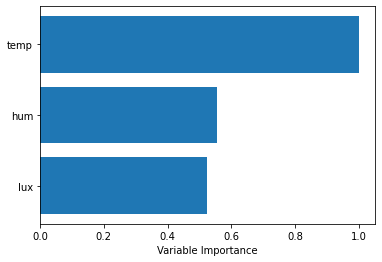

In [26]:
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()

# 6. 모델 활용하기
- 위에서 만들어진 설문조사 대상의 RandomForest Model 을 어떻게 활용할 수 있는지 확인해본다.

## 6-1. 적합도 (오차 확인)
- 다시 한번 임의의 설문조사를 진행해보고, 실제 사용자 평균 점수와 설문조사 대상의 RandomForest Model이 예측한 값의 오차를 확인한다. 이로써 해당 모델이 예측을 잘 해내는지에 대한 적합도를 확인해보자.

In [27]:
new_survey = pd.DataFrame(columns=['온도','습도','조도','실제 설문 점수 (평균)', '예측 설문 점수', '오차'])

for days in range(0, 500):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    
    np_features = np.array([[ran_temp / max_temp,
                             ran_hum / max_hum, 
                             ran_lux / max_lux]])
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    new_survey.loc[days] = [
        ran_temp,
        ran_hum,
        ran_lux,
        user_scores.mean(),
        RFModel.predict(np_features)[0],
        abs(user_scores.mean() - RFModel.predict(np_features)[0])
    ]

In [28]:
print("해당 모델의 오차 평균은 {}점 입니다.".format(round(new_survey['오차'].mean() * 1000) / 1000))
new_survey.head()

해당 모델의 오차 평균은 0.339점 입니다.


,온도,습도,조도,실제 설문 점수 (평균),예측 설문 점수,오차
0,16.0,34.0,1400.0,54.66,54.9546,0.2946
1,19.0,77.0,400.0,53.04,52.6354,0.4046
2,17.0,63.0,1900.0,53.22,53.6196,0.3996
3,18.0,54.0,600.0,55.68,55.5956,0.0844
4,21.0,73.0,1200.0,54.20,54.1814,0.0186


## 6-2 특징 별 참여자들 선호 구간 확인하기
- 위에서 모델의 적합도를 살펴봤다. 오차도 그렇게 크지 않은 수치를 나타냈기 때문에, 충분히 예측모델로서의 가치가 있다고 생각을 한다.
- 예측모델이 만들어졌으니, 특징 별로 변화를 주어 설문점수를 예측하는 것이 가능해졌다. 아래는 한 개의 특징에만 변화를 주고, 나머지 특징은 고정값으로 놔두면서 사용자의 점수가 높아지는 구간 이동평균을 통해서 확인할 것 이고, 이를 통해 특징 별 참여자들이 가장 선호 하는 구간을 확인하는 과정을 보여준다.

### 6-2-1. 온도

In [29]:
temp_move_mean = pd.DataFrame(columns=["온도", "예측 설문 점수"])

for temp in range(10, 30):
    static_hum = 0
    static_lux = 0
    
    np_features = np.array([[temp / max_temp,
                           static_hum / max_hum,
                           static_lux / max_lux]])
    temp_move_mean = temp_move_mean.append({
        "온도": temp,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
temp_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 온도', '최대 온도', '이동평균'])
    
for w_size in range(3, round(len(temp_move_mean))):
    move_mean = temp_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_temp = temp_move_mean.iloc[min_idx]['온도']
    move_max_temp = temp_move_mean.iloc[max_idx]['온도']
    
    temp_move_mean_chk = temp_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 온도": move_min_temp,
        "최대 온도": move_max_temp,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)

s_tmmc = temp_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()
temp_move_mean_chk.head()

,이동평균사이즈,최소 온도,최대 온도,이동평균
0,3.0,19.0,21.0,52.316467
1,4.0,19.0,22.0,52.303750
2,5.0,18.0,22.0,52.285720
3,6.0,17.0,22.0,52.279767
4,7.0,16.0,22.0,52.272486


### 6-2-2. 습도

In [30]:
hum_move_mean = pd.DataFrame(columns=["습도", "예측 설문 점수"])

for hum in range(30, 81):
    static_temp = 0
    static_lux = 0
    
    np_features = np.array([[static_temp / max_temp,
                           hum / max_hum,
                           static_lux / max_lux]])
    hum_move_mean = hum_move_mean.append({
        "습도": hum,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
hum_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 습도', '최대 습도', '이동평균'])

for w_size in range(3, round(len(hum_move_mean))):
    move_mean = hum_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_hum = hum_move_mean.iloc[min_idx]['습도']
    move_max_hum = hum_move_mean.iloc[max_idx]['습도']
    
    hum_move_mean_chk = hum_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 습도": move_min_hum,
        "최대 습도": move_max_hum,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)
    
s_hmmc = hum_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()    
hum_move_mean_chk.head()

,이동평균사이즈,최소 습도,최대 습도,이동평균
0,3.0,41.0,43.0,51.701244
1,4.0,41.0,44.0,51.691217
2,5.0,41.0,45.0,51.683973
3,6.0,41.0,46.0,51.677244
4,7.0,41.0,47.0,51.663010


### 6-2-3. 조도

In [31]:
lux_move_mean = pd.DataFrame(columns=["조도", "예측 설문 점수"])

for lux in range(200, 2000, 100):
    static_temp = 0
    static_hum = 0
    
    np_features = np.array([[static_temp / max_temp,
                           static_hum / max_hum,
                           lux / max_lux]])
    lux_move_mean = lux_move_mean.append({
        "조도": lux,
        "예측 설문 점수": RFModel.predict(np_features)[0]
    }, ignore_index=True)
    
lux_move_mean_chk = pd.DataFrame(columns=['이동평균사이즈','최소 조도', '최대 조도', '이동평균'])

for w_size in range(3, round(len(lux_move_mean))):
    move_mean = lux_move_mean['예측 설문 점수'].rolling(window=w_size).mean()
    max_idx = move_mean.argmax()
    min_idx = max_idx - (w_size - 1)
    
    move_min_lux = lux_move_mean.iloc[min_idx]['조도']
    move_max_lux = lux_move_mean.iloc[max_idx]['조도']
    
    lux_move_mean_chk = lux_move_mean_chk.append({
        "이동평균사이즈": w_size,
        "최소 조도": move_min_lux,
        "최대 조도": move_max_lux,
        "이동평균": move_mean[max_idx]
    }, ignore_index=True)
    
s_lmmc = lux_move_mean_chk.sort_values(by=['이동평균'], ascending=False).copy()
lux_move_mean_chk.head()

,이동평균사이즈,최소 조도,최대 조도,이동평균
0,3.0,1200.0,1400.0,52.923333
1,4.0,1200.0,1500.0,52.904400
2,5.0,1000.0,1400.0,52.897680
3,6.0,900.0,1400.0,52.894500
4,7.0,800.0,1400.0,52.896229


In [32]:
prefer_features = [
    [
        s_tmmc.iloc[0]['최소 온도'], s_tmmc.iloc[0]['최대 온도']
    ],
    [
        s_hmmc.iloc[0]['최소 습도'], s_hmmc.iloc[0]['최대 습도']
    ],
    [
        s_lmmc.iloc[0]['최소 조도'], s_lmmc.iloc[0]['최대 조도']
    ]
]

print("사용자들이 가장 선호하는 특징별 구간은 아래와 같습니다.")
print("온도 : {} ~ {}".format(prefer_features[0][0],prefer_features[0][1]))
print("습도 : {} ~ {}".format(prefer_features[1][0],prefer_features[1][1]))
print("조도 : {} ~ {}".format(prefer_features[2][0],prefer_features[2][1]))

사용자들이 가장 선호하는 특징별 구간은 아래와 같습니다.
온도 : 19.0 ~ 21.0
습도 : 41.0 ~ 43.0
조도 : 1200.0 ~ 1400.0


#### 실제로 참여도가 높은 참여자 객체를 만들 때, 온도는 18 ~ 20 구간, 습도는 40 ~ 60 구간, 조도는 700 ~ 1500 구간에서 점수를 높게 주도록 설정해놨으며, 설문조사 대상의 RandomForest 모델의 예측 결과들의 이동평균을 구해, 이동평균이 가장 높았던 구간을 뽑아내면 해당 구간 안에 있는 특징 별 선호 구간을 찾아낼 수 있었다.
---

In [33]:
temp_range = range(
    int(prefer_features[0][0]), int(prefer_features[0][1] + 1)
)
hum_range = range(
    int(prefer_features[1][0]), int(prefer_features[1][1] + 1)
)
lux_range = range(
    int(prefer_features[2][0]), int(prefer_features[2][1] + 1), 50
)

combinations = np.array([])
for _temp in temp_range:
    for _hum in hum_range:
        for _lux in lux_range:
            combinations = np.append(
                combinations,
                [_temp, _hum, _lux]
            )

In [34]:
last_test = pd.DataFrame(columns=['온도', '습도', '조도', '실제 설문조사 평균값','예측값'])

for _temp, _hum, _lux in combinations.reshape(-1, 3):
    np_features = np.array([[
        _temp / max_temp,
        _hum / max_hum,
        _lux / max_lux
    ]])
    pre = RFModel.predict(np_features)[0]
    
    user_scores = np.array([])
    for user_idx in range(0,50):
        _s = users[user_idx].score(ran_temp,
                       ran_hum,
                       ran_lux)
        user_scores = np.append(user_scores,
                               _s)
    
    last_test = last_test.append({
        "온도": _temp,
        "습도": _hum,
        "조도": _lux,
        "실제 설문조사 평균값": user_scores.mean(),
        "예측값": pre
    }, ignore_index=True)
    
last_test['오차']  = abs(last_test['실제 설문조사 평균값'] - last_test['예측값'])

In [35]:
last_test.sort_values(by=['예측값'], ascending=[False]).head()

,온도,습도,조도,실제 설문조사 평균값,예측값,오차
14,19.0,43.0,1400.0,54.14,56.1138,1.9738
9,19.0,42.0,1400.0,53.74,56.1120,2.3720
4,19.0,41.0,1400.0,53.64,56.1044,2.4644
8,19.0,42.0,1350.0,53.56,56.0878,2.5278
13,19.0,43.0,1350.0,53.84,56.0862,2.2462
